# Function optimization using Evolutionary Learning
                                                              
                                                              Xiaomei Huang

## 1 Background

Genetic algorithms can effectively be used to find the maxima/minima of a function,
by searching the function variable space to find the global optimum.
This project is to simulate natural selection via the genetic algorithm, and find out
the global minimum of some math functions.


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import timeit
import math

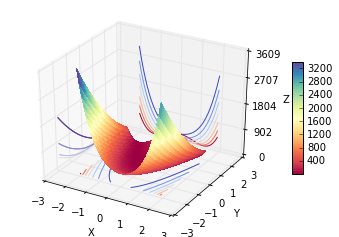

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

#Rosenbrock’s banana function
def bananaFunc(x,y):
    return (1-x)**2 + 100*(y-x**2)**2

#Visualize the function
x = arange(-2.0,2.0,0.1)
y = arange(-2.0,2.0,0.1)
X,Y = meshgrid(x, y) 
Z = bananaFunc(X,Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.Spectral,linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(5))
fig.colorbar(surf, shrink=0.5, aspect=10)
cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-3, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=3, cmap=cm.coolwarm)
ax.set_xlabel('X')
ax.set_xlim(-3, 3)
ax.set_ylabel('Y')
ax.set_ylim(-3, 3)
ax.set_zlabel('Z')

#ax.view_init(elev=40., azim=225)

In [3]:
# the Goldstein-Price function

def goldPriceFunc(x,y):
    return (((x+y+1)**2)*(19-14*x+3*x**2-14*y+6*x*y+3*y**2)+1)\
*(((2*x-3*y)**2)*(18-32*x + 12*x**2+48*y-36*x*y+27*y**2)+30)

In [4]:
# randomly generate x,y
def generateXY(min,max,n):
    return (max - min) * np.random.random(n) - max

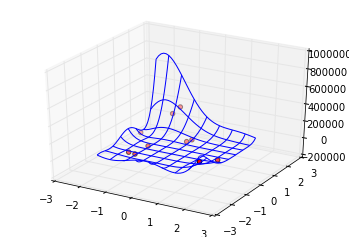

In [5]:
# plot Goldstein-Price function with some randomly generated points
x = arange(-2.0,2.0,0.1)
y = arange(-2.0,2.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = goldPriceFunc(X,Y)
fig = plt.figure()
ax = fig.gca(projection='3d') 
ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)
x = generateXY(-2,2,10)
y = generateXY(-2,2,10)
z = goldPriceFunc(x,y)
ax.scatter(x,y,z, c='r')

## 1. Initialization: 
### Generate a population of candidate solutions

In [6]:
# generate 100 candidates
X = generateXY(-2,2,100)
Y = generateXY(-2,2,100)
Z = goldPriceFunc(X,Y)

## 2. Evaluation: 
### Calculate the “fitness” of each member of the population

In [7]:
# Will compare the fitness to the parents if exists
# Choose the best fitness as 1
def fit(X,Y,func,mini=None):
    Z = func(X,Y)
    #print(Z)
    if mini == None:
        mini = min(Z)
    else:
        if min(Z) < mini:
            mini  = min(Z)
    if max(Z)-mini < 1e-5:
        return np.ones(len(Z))
    else:
        return (max(Z)-Z)/(max(Z)-mini)   
fitness = fit(X,Y,goldPriceFunc)

## 3. Selection: 
### Probabilistically choose a subset of the population to survive ” of each member of the population

In [8]:
# Survival probability:
def survival(fit):
    surv = fit/sum(fit)
    return surv
surv= survival(fitness)
#surv

In [9]:
# Construct dataframe to store data and order by survival probability
df = pd.DataFrame()
df['X']=X
df['Y']=Y
df['Z']=Z
df['fitness']=fitness
df['surv']=surv
df = df.sort('surv', ascending=False)
df.head()

,X,Y,Z,fitness,surv
32,0.069957,-1.151607,25.415941,1.000000,0.011207
58,-0.475580,-0.604737,43.229549,0.999968,0.011207
37,-0.321760,-1.148272,47.715417,0.999960,0.011207
76,1.403855,-0.118837,130.531092,0.999810,0.011205
21,-0.477274,-1.234955,134.788955,0.999803,0.011205


In [10]:

# Randomly select the individuals by roulette wheel selection
def select(n,df):
    rds = np.random.random(n)
    f = np.cumsum(np.array(df['surv']))
    sel = np.zeros(n, dtype=int) 
    for i, s in enumerate(rds):
        for j, m in enumerate(f):
            if m > s:
                sel[i] = j
                break
    return sel

# get the selected location in dataframe
s = select(100,df)

In [11]:
# Seleted individuals
dfSel = df.iloc[s]
dfSel.head()

,X,Y,Z,fitness,surv
56,1.893024,1.099764,2095.793963,0.996267,0.011165
85,-1.081095,-0.429085,744.193953,0.998704,0.011193
67,1.879180,-0.251161,5055.219764,0.990932,0.011106
36,-0.118062,0.817529,19987.416731,0.964009,0.010804
28,1.984691,-0.263934,7349.260137,0.986795,0.011059


# 4. Variation: 
## Permute chromosomes using genetic operators (crossover, mutation):

In [12]:
# encode the x,y real values into a chromosome
def toChrom(individual,length):
    rd = np.random.random(length)
    return individual*rd/sum(rd)

def toIndiv(chrom):
    return sum(chrom)

# set chromosome length
n= 8

# expressed by chromosomes-like style
chromX = []
for x in dfSel['X']:
    chrom = toChrom(x,n)
    chromX.append(chrom)
#print(chromX)

chromY = []
for y in dfSel['Y']:
    chrom = toChrom(y,n)
    chromY.append(chrom)
#print(chromY)

In [13]:
# Store in dataframe
chromXdf = pd.DataFrame(chromX)
chromYdf = pd.DataFrame(chromY)
chromXdf.head()

,0,1,2,3,4,5,6,7
0,0.378772,0.028708,0.040093,0.138749,0.209301,0.403910,0.191904,0.501588
1,-0.096956,-0.018101,-0.048731,-0.128142,-0.047825,-0.375069,-0.000321,-0.365950
2,0.377580,0.084100,0.105701,0.051998,0.236579,0.466989,0.178574,0.377660
3,-0.030705,-0.008805,-0.004817,-0.006552,-0.011551,-0.021128,-0.003087,-0.031418
4,0.174409,0.511364,0.222777,0.037673,0.214208,0.212632,0.282801,0.328828


## Crossover:

In [14]:

def crossOver(df):
    newDF = pd.DataFrame()
    for i in range(int(len(df)/2)):
        pair = pd.DataFrame.sample(df,2)
        crossLen= np.random.randint(1,len(df.columns)-1)
        x1 = pair.iloc[0][:crossLen].append(pair.iloc[1][crossLen:])
        new_x1 = pd.DataFrame(x1).transpose()
        x2 = pair.iloc[1][:crossLen].append(pair.iloc[0][crossLen:])
        new_x2 = pd.DataFrame(x2).transpose()
        newDF = newDF.append(new_x1)
        newDF = newDF.append(new_x2)
    return newDF

newChromX = crossOver(chromXdf)
newChromY = crossOver(chromYdf)
newChromX.head()

,0,1,2,3,4,5,6,7
0,-0.304727,-0.226001,-0.020751,-0.001873,-0.023675,-0.124449,-0.098337,-0.001870
0,-0.014361,-0.137411,-0.100831,-0.125744,-0.150746,-0.222340,-0.222444,-0.419745
0,0.053996,0.041764,0.044463,0.017072,0.031773,0.033601,0.040560,0.042316
0,0.034755,0.051971,0.003999,0.006327,0.059359,0.025713,0.025565,0.018816
0,0.295772,0.451359,0.097334,0.156542,0.090071,0.253140,0.049582,0.353084


## Mutation And update population :

In [15]:

mutRate = 0.02
def mutate(chroms,mutRate):
    temp = np.array(chroms)
    for i in range(len(temp)):
        for j in range(len(temp[i])):
            if np.random.random()<mutRate:
                #print(temp[i][j])
                mutor = np.random.random()
                temp[i][j] +=mutor
    chroms = pd.DataFrame(temp)
    return chroms   
newChromX = mutate(newChromX,mutRate)
newChromY = mutate(newChromY,mutRate)
newChromX.head()

,0,1,2,3,4,5,6,7
0,-0.304727,-0.226001,-0.020751,-0.001873,-0.023675,-0.124449,-0.098337,-0.001870
1,-0.014361,-0.137411,-0.100831,-0.125744,-0.150746,-0.222340,-0.222444,-0.419745
2,0.053996,0.041764,0.044463,0.017072,0.031773,0.033601,0.040560,0.042316
3,0.034755,0.051971,0.003999,0.006327,0.059359,0.025713,0.025565,0.018816
4,0.295772,0.451359,0.097334,0.156542,0.090071,0.253140,0.115113,0.353084


## Termination: terminated by defined generations size

# 5. Evolution by generations

In [16]:

def evolve(vmin,vmax,func,size,chromsize,gens,goal=None,mutRate=0.02,crossRate = 0.9):
    #initial
    X = generateXY(vmin,vmax,size)
    Y = generateXY(vmin,vmax,size)
    Z = func(X,Y)
    #fitness
    if goal is not None:
        minZ = goal['Z']
    else:
        minZ = None
    fitness = fit(X,Y,func,minZ)
    surv= survival(fitness)
    surfDF = pd.DataFrame()
    surfDF['X']=X
    surfDF['Y']=Y
    surfDF['Z']=Z
    surfDF['fitness']=fitness
    surfDF['surv']=surv
    surfDF = surfDF.sort('surv', ascending=False)
    #print(surfDF)
    if goal is not None:
        if surfDF.iloc[0]['Z'] > minZ:
            solution = goal
    else:
        solution = surfDF.iloc[0]
        minZ = surfDF.iloc[0]['Z']
    zs = []
    zs.append(minZ)
    
    for g in range(gens):
        s = select(size,df)
        dfSel = df.iloc[s]
        
        #Variation: permute chromosomes using genetic operators (crossover, mutation):
        n= chromsize
        chromX = []
        for x in dfSel['X']:
            chrom = toChrom(x,n)
            chromX.append(chrom)

        chromY = []
        for y in dfSel['Y']:
            chrom = toChrom(y,n)
            chromY.append(chrom)
    
        chromXdf = pd.DataFrame(chromX)
        chromYdf = pd.DataFrame(chromY)
        
        # Crossover
        if np.random.random()<crossRate:
            newChromX = crossOver(chromXdf)
        else: newChromX = chromXdf
        if np.random.random()<crossRate:
            newChromY = crossOver(chromYdf)
        else: newChromY = chromYdf
        
        # Mutation        
        newChromX = mutate(newChromX,mutRate)    
        newChromY = mutate(newChromY,mutRate)
        
        X = newChromX.sum(axis = 1)
        
        Y = newChromY.sum(axis = 1)
        Z = func(X,Y)
        #fitness
        fitness = fit(X,Y,func,minZ)
        surv= survival(fitness)
        surfDF = pd.DataFrame()
        surfDF['X']=X
        surfDF['Y']=Y
        surfDF['Z']=Z
        surfDF['fitness']=fitness
        surfDF['surv']=surv
        surfDF = surfDF.sort('surv', ascending=False)
        #print(surfDF)

        if surfDF.iloc[0]['Z'] < minZ:
            minZ = surfDF.iloc[0]['Z']
            solution = surfDF.iloc[0]
        else:
            surfDF.iloc[-1]=solution
        zs.append(minZ)   
    print(solution)
    return solution,zs          

## Test functions:

### Rosenbrock’s banana function

X          1.025358
Y          1.040780
Z          0.011836
fitness    1.000000
surv       0.025968
Name: 30, dtype: float64
Running Time:  54.04964693496004


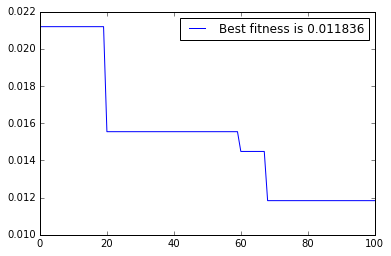

In [17]:

start = timeit.default_timer()
banana1,zs1 = evolve(-2,2,bananaFunc,50,20,100)
stop = timeit.default_timer()
print ("Running Time: ",stop - start )
plt.plot(zs1,label='Best fitness is %f' % (zs1[-1]))
plt.legend(loc='best')

X          0.940855
Y          0.890113
Z          0.005903
fitness    1.000000
surv       0.010374
Name: 40, dtype: float64
Running Time:  89.9310043550795


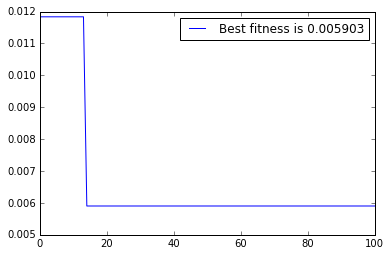

In [18]:
# pass the 'known' best fitness to continue test, change the population size
start = timeit.default_timer()
banana2,zs2 = evolve(-2,2,bananaFunc,100,20,100,banana1)
stop = timeit.default_timer()
print ("Running Time: ",stop - start )
plt.plot(zs2,label='Best fitness is %f' % (zs2[-1]))
plt.legend(loc='best')

X          0.997111
Y          0.998461
Z          0.001799
fitness    1.000000
surv       0.025101
Name: 48, dtype: float64
Running Time:  495.36066849692725


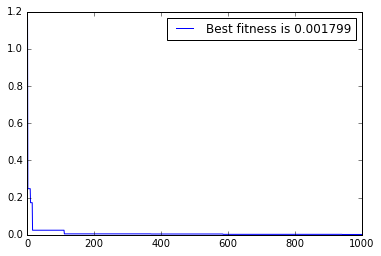

In [19]:
# Try to evolve for more generations
start = timeit.default_timer()
banana3,zs3 = evolve(-2,2,bananaFunc,50,20,1000)
stop = timeit.default_timer()
print ("Running Time: ",stop - start )
plt.plot(zs3,label='Best fitness is %f' % (zs3[-1]))
plt.legend(loc='best')

#### Result:

* X:          0.997111
* Y:          0.998461
* Z:          0.001799



### Test Goldstein-Price function:

X         -0.002698
Y         -1.027656
Z          3.334879
fitness    1.000000
surv       0.021891
Name: 37, dtype: float64
Running Time:  51.178181909024715


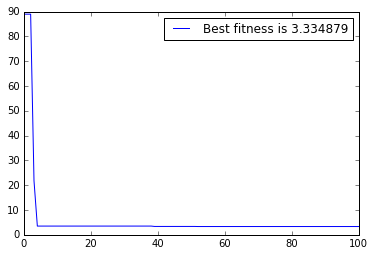

In [22]:
start = timeit.default_timer()
gold1,gs1 = evolve(-2,2,goldPriceFunc,50,20,100)
stop = timeit.default_timer()
print ("Running Time: ",stop - start )
plt.plot(gs1,label='Best fitness is %f' % (gs1[-1]))
plt.legend(loc='best')

X          0.025855
Y         -0.986721
Z          3.167203
fitness    1.000000
surv       0.020708
Name: 1, dtype: float64
Running Time:  49.179733750992455


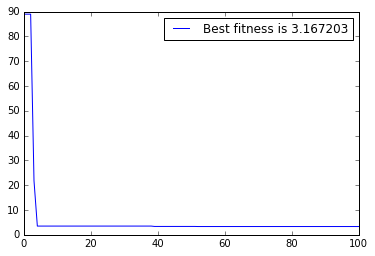

In [23]:
start = timeit.default_timer()
gold,gs = evolve(-2,2,goldPriceFunc,50,20,100,mutRate=0.1)
stop = timeit.default_timer()
print ("Running Time: ",stop - start )
plt.plot(gs1,label='Best fitness is %f' % (gs[-1]))
plt.legend(loc='best')

X          0.011724
Y         -1.000627
Z          3.036746
fitness    1.000000
surv       0.022129
Name: 44, dtype: float64
Running Time:  57.2276400210103


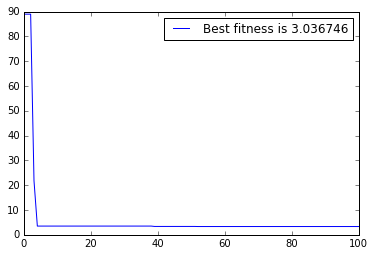

In [24]:
start = timeit.default_timer()
gold,gs = evolve(-2,2,goldPriceFunc,50,20,100,mutRate=0.08, crossRate=1)
stop = timeit.default_timer()
print ("Running Time: ",stop - start )
plt.plot(gs1,label='Best fitness is %f' % (gs[-1]))
plt.legend(loc='best')

In [33]:
start = timeit.default_timer()
gold,gs = evolve(-2,2,goldPriceFunc,50,10,200,mutRate=0.08, crossRate=1)
stop = timeit.default_timer()
print ("Running Time: ",stop - start )

X          0.006910
Y         -1.000752
Z          3.013483
fitness    1.000000
surv       0.020523
Name: 41, dtype: float64
Running Time:  118.20993676199578


#### Result: 

* X:           0.006910
* Y:          -1.000752
* Z:           3.013483

## Visualization

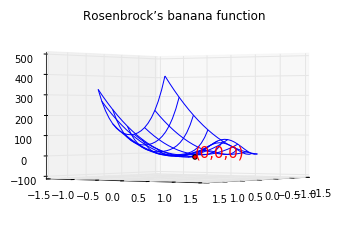

In [85]:
x = arange(-1.0,1.0,0.1)
y = arange(-1.0,1.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = bananaFunc(X,Y)
fig = plt.figure()
ax = fig.gca(projection='3d') 
ax.plot_wireframe(X, Y, Z, rstride=3, cstride=3)
x = banana3['X']
y = banana3['Y']
z = bananaFunc(x,y)
ax.scatter(x,y,z, c='r')
ax.text(x,y,z,  '(%d,%d,%d)' % (x,y,z), size=15, zorder=1, color='r') 
ax.view_init(elev=0., azim=35)
plt.title('Rosenbrock’s banana function')

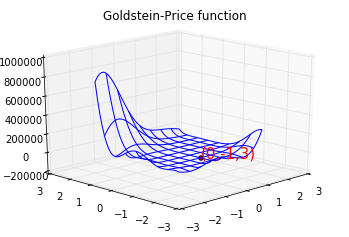

In [94]:
x = arange(-2.0,2.0,0.1)
y = arange(-2.0,2.0,0.1)
X,Y = meshgrid(x, y) # grid of point
Z = goldPriceFunc(X,Y)
fig = plt.figure()
ax = fig.gca(projection='3d') 
ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)
x = gold['X']
y = gold['Y']
z = goldPriceFunc(x,y)
ax.scatter(x,y,z, c='r')
ax.text(x,y,z,  '(%d,%d,%d)' % (x,y,z), size=15, zorder=1, color='r') 
ax.view_init(elev=20., azim=225)
plt.title('Goldstein-Price function')


# Discussion:

* In this model, there are some parameters would affect the results, including the population size, mutation rate, crossover rate, and the chromosome length. 
 
* Not very efficient: The average time to run a test with 50 samples, 20 bases and 100 generations takes around 50 seconds. It seems that the more generations evolved, the more precise results it got. But the processing time is the issue.


* Since we don't know what is the best 'fitness', so the terminal term here just defined by generation numbers.


* No guarantee of finding global minima. But result gets better with time


* The evolution is in the black box. Fine tuning all the parameters, such as mutation rate,crossover rate, genetic encoding etc, might be just useless, and no good results guarantee.